In [1]:
# Import all libraries needed for the tutorial
#what is my goal here? Easily plot all three voltage phases and all three current phases on
#seperate graphs. Then I would try to use this tool for different time frequencies, then see if this makes sense. 
#ok so now I know how to do things, what do I do now? I can take any voltage and current, and potentially turn 
#things all to p.u. now. But now I think I should just plot p.u. for each 



#things I need to present: 
# 1. why I went straight from the generator model to grid model without putting the generator on deltamode: 
#    basically what I saw was that the generator model worked fine until I took delta-mode off of the recorders
#   when I did that, I saw that they just pasted the last result of deltamode for the generators to most of the
#   timesteps when there was no delta mode. This reflects what happens on the other IEEE13 glm file

# 2. Show that in deltamode, the voltage and the current on the inverter behaves correctly, and the inverter shuts
# off when it needs to. 
    # I will have to show the voltage A, B and C plots
    # put in p.u.
    # show all the little data points on my graph (scatter)
    # Put current A, B, C, show side by side
    # show the climate data (if possible, signifying when the sun comes up)
    # Explain how when the voltage all of a sudden spikes up from one timestep to the next, then the thing goes
    # into delta mode, then at delta mode, if the voltage is 1.05 above nominal, the voltage will stay there 
    # for about a second until it shuts down. 

# 3. I want to show that voltage and current are fairly reasonable when I put every recorder on delta-mode. 
# I had to switch up the model so then I had to put a recorder on every meter, but with pandas, I can easily
# manipulate data



# General syntax to import specific functions in a library: 
##from (library) import (specific library function)
from pandas import DataFrame, read_csv
from pandas._libs.tslib import Timestamp
from pandas.core.indexes.datetimes import DatetimeIndex
import pandas as pd
import numpy as np

# General syntax to import a library but no functions: 
##import (library) as (give the library a nickname/alias)
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number

# Enable inline plotting
%matplotlib inline

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 3.6.2 |Anaconda custom (x86_64)| (default, Jul 20 2017, 13:14:59) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
Pandas version 0.22.0
Matplotlib version 2.1.2


In [2]:
import matplotlib.dates as mdates
import math
import cmath
def get_voltage_df(filename):
    data = pd.read_csv(filename,skiprows=8,
                       usecols=['# timestamp','voltage_A.real', 'voltage_A.imag'
                               ,'voltage_B.real', 'voltage_B.imag'
                               ,'voltage_C.real', 'voltage_C.imag'], parse_dates=['# timestamp'])
    data['voltageA'] = data.apply(lambda x: complex(x[1],x[2]), axis=1)
    data['tstep'] = data['# timestamp'].astype('int64')
    data['voltageA_mag'] = data.apply(lambda x: abs(complex(x[1],x[2])), axis=1)
    data['voltageA_deg'] = data.apply(lambda x: cmath.phase(complex(x[1],x[2])) * 180 / (2 * math.pi), axis=1)
    data['voltageB_mag'] = data.apply(lambda x: abs(complex(x[3],x[4])), axis=1)
    data['voltageB_deg'] = data.apply(lambda x: cmath.phase(complex(x[3],x[4])) * 180 / (2 * math.pi), axis=1)
    data['voltageC_mag'] = data.apply(lambda x: abs(complex(x[5],x[6])), axis=1)
    data['voltageC_deg'] = data.apply(lambda x: cmath.phase(complex(x[5],x[6])) * 180 / (2 * math.pi), axis=1)
    
    pu_voltage = 2407.11
    
    data['voltageA_mag_pu'] = data['voltageA_mag'] / pu_voltage
    data['voltageB_mag_pu'] = data['voltageB_mag'] / pu_voltage
    data['voltageC_mag_pu'] = data['voltageC_mag'] / pu_voltage
    data.set_index('# timestamp',inplace=True)
    return data


In [3]:
from datetime import datetime as dt

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n * 2)

def make_mini_plots(my_lbl, df=None, time_start='2000-08-02 12:05:00', time_end='2000-08-02 12:05:05', toggle_data=False, fname=None, df_list=None):
    fig, ax = plt.subplots(figsize=(10,6))
    if df_list:
        cmap = get_cmap(len(df_list) * 2)
        for i,d in enumerate(df_list):
            d[time_start:time_end][['tstep',my_lbl]].plot(x='tstep', y = my_lbl, kind='scatter',ax=ax,c=cmap(i), label=str(i))
            print(cmap(i))
    else:
        df[time_start:time_end][['tstep',my_lbl]].plot(x='tstep', y = my_lbl, kind='scatter',ax=ax)
    ax.set_xticklabels([dt.fromtimestamp(ts / 1e9).strftime('%H:%M:%S') for ts in ax.get_xticks()])
    if toggle_data:
        print(df[time_start:time_end][['tstep',my_lbl]])
    if fname:
        fig.savefig('cmpIEEE13plts/'+ fname + '.png')
    



In [4]:
def get_current_df(filename):
    cdata = pd.read_csv(filename,skiprows=8,
                       usecols=['# timestamp','measured_current_A.real', 'measured_current_A.imag'
                               ,'measured_current_B.real', 'measured_current_B.imag'
                               ,'measured_current_C.real', 'measured_current_C.imag'], parse_dates=['# timestamp'])
    cdata['tstep'] = cdata['# timestamp'].astype('int64')
    cdata['currentA_mag'] = cdata.apply(lambda x: abs(complex(x[1],x[2])), axis=1)
    cdata['currentA_deg'] = cdata.apply(lambda x: cmath.phase(complex(x[1],x[2])) * 180 / (2 * math.pi), axis=1)
    cdata['currentB_mag'] = cdata.apply(lambda x: abs(complex(x[3],x[4])), axis=1)
    cdata['currentB_deg'] = cdata.apply(lambda x: cmath.phase(complex(x[3],x[4])) * 180 / (2 * math.pi), axis=1)
    cdata['currentC_mag'] = cdata.apply(lambda x: abs(complex(x[5],x[6])), axis=1)
    cdata['currentC_deg'] = cdata.apply(lambda x: cmath.phase(complex(x[5],x[6])) * 180 / (2 * math.pi), axis=1)
    cdata.set_index('# timestamp',inplace=True)
    return cdata



In [ ]:
data = get_voltage_df('time_results/meter_data/voltage/m680.csv')


#set date as index
# data.set_index('# timestamp',inplace=True)

#plot data
fig, ax = plt.subplots(figsize=(15,7))
data[['voltageA_mag','voltageA_deg']].plot(ax=ax)

#set ticks every week
ax.xaxis.set_major_locator(mdates.HourLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))

In [ ]:

make_mini_plots('voltageA_mag_pu',data,time_start='2000-08-02 12:00:00', time_end='2000-08-02 12:30:05')
make_mini_plots('voltageB_mag_pu',data,time_start='2000-08-02 12:00:00', time_end='2000-08-02 12:30:05')
make_mini_plots('voltageC_mag_pu',data,time_start='2000-08-02 12:00:00', time_end='2000-08-02 12:30:05')

In [ ]:

#set date as index
cdata = get_current_df('time_results/meter_data/current/m680.csv')

#plot data
fig, ax = plt.subplots(figsize=(15,7))
cdata[['currentA_mag','currentA_deg']].plot(ax=ax)

#set ticks every week
ax.xaxis.set_major_locator(mdates.HourLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))

In [ ]:

make_mini_plots('currentA_mag',df=cdata,time_start='2000-08-02 12:05:00', time_end='2000-08-02 12:05:05')
make_mini_plots('currentB_mag',df=cdata,time_start='2000-08-02 12:05:00', time_end='2000-08-02 12:05:05')
make_mini_plots('currentC_mag',df=cdata,time_start='2000-08-02 12:05:00', time_end='2000-08-02 12:05:05')


In [ ]:
make_mini_plots('currentA_mag',df=cdata,time_start='2000-08-02 12:10:00', time_end='2000-08-02 12:10:04', toggle_data=True)
make_mini_plots('voltageA_mag',df=data,time_start='2000-08-02 12:10:00', time_end='2000-08-02 12:10:04', toggle_data=True)


In [ ]:
make_mini_plots('currentA_mag',df=cdata,time_start='2000-08-02 12:10:00', time_end='2000-08-02 12:10:04')
make_mini_plots('voltageA_mag',df=data,time_start='2000-08-02 12:10:00', time_end='2000-08-02 12:10:04')


In [5]:
vdata_ctrl = get_voltage_df('time_results/meter_data_ctrl/voltage/m680.csv')
cdata_ctrl = get_current_df('time_results/meter_data_ctrl/current/m680.csv')


In [6]:
vdata_new = get_voltage_df('time_results/meter_data/voltage/m680.csv')
cdata_new = get_current_df('time_results/meter_data/current/m680.csv')

In [7]:
vdata_nodelta = get_voltage_df('time_results/meter_data_nodelta/voltage/m680.csv')
cdata_nodelta = get_current_df('time_results/meter_data_nodelta/current/m680.csv')

In [8]:
vdata_gen = get_voltage_df('time_results/meter_data_gen/voltage/m680.csv')
cdata_gen = get_current_df('time_results/meter_data_gen/current/m680.csv')

(1.0, 0.0, 0.0, 1.0)
(1.0, 0.39375039375039367, 0.0, 1.0)
(1.0, 0.78750078750078734, 0.0, 1.0)
(0.81874881874881889, 1.0, 0.0, 1.0)


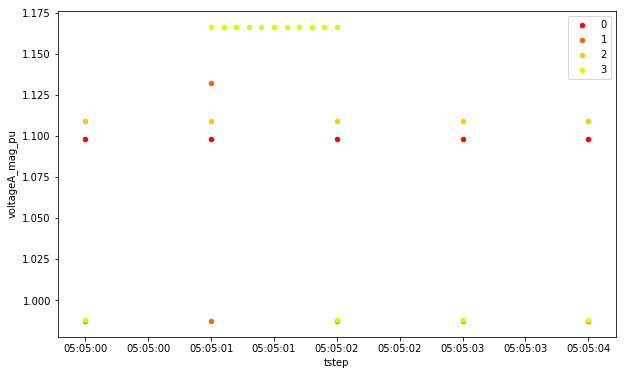

In [13]:
make_mini_plots('voltageA_mag_pu',df_list=[vdata_ctrl, vdata_new, vdata_nodelta, vdata_gen],
                time_start='2000-08-02 12:05:00', time_end='2000-08-02 12:05:04', fname='voltage_finer_day')





(1.0, 0.0, 0.0, 1.0)
(1.0, 0.39375039375039367, 0.0, 1.0)
(1.0, 0.78750078750078734, 0.0, 1.0)
(0.81874881874881889, 1.0, 0.0, 1.0)


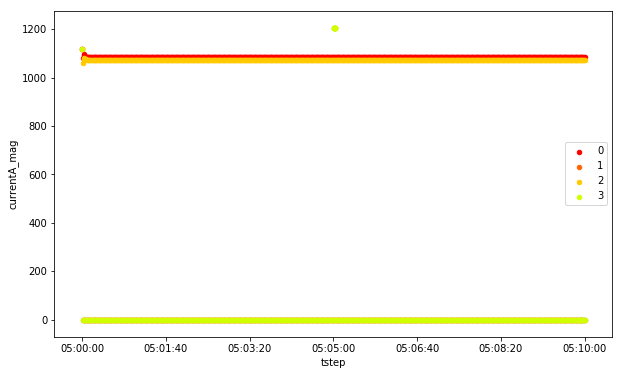

In [10]:
make_mini_plots('currentA_mag',df_list=[cdata_ctrl, cdata_new, cdata_nodelta, cdata_gen],
                time_start='2000-08-02 12:00:00', time_end='2000-08-02 12:10:00', fname='voltage_finer_day')

In [51]:
vdata_nodelta2 = get_voltage_df('time_results/meter_data_nodelta/voltage/m680.csv')
cdata_nodelta2 = get_current_df('time_results/meter_data_nodelta/current/m680.csv')

In [129]:
vdata_gen2 = get_voltage_df('time_results/meter_data_gen/voltage/m680.csv')
cdata_gen2 = get_current_df('time_results/meter_data_gen/current/m680.csv')

In [166]:
vdata_inv = get_voltage_df('time_results/meter_data_inv/voltage/m680.csv')
cdata_inv = get_current_df('time_results/meter_data_inv/current/m680.csv')

KeyboardInterrupt: 

In [162]:
vdata_inv2 = get_voltage_df('time_results/meter_data_inv_2/voltage/m680.csv')
cdata_inv2 = get_current_df('time_results/meter_data_inv_2/current/m680.csv')

In [163]:
vdata_inv[:][['voltageA_mag']]


,voltageA_mag
# timestamp,
2000-08-02 00:00:00,2378.224819
2000-08-02 00:00:01,2378.224819
2000-08-02 00:00:02,2378.224819
2000-08-02 00:00:03,2378.224819
2000-08-02 00:00:04,2378.224819
2000-08-02 00:00:05,2378.224819
2000-08-02 00:00:06,2378.224819
2000-08-02 00:00:07,2378.224819
2000-08-02 00:00:08,2378.224819


(1.0, 0.0, 0.0, 1.0)
(0.81874881874881889, 1.0, 0.0, 1.0)
(0.0, 1.0, 0.36250047249749562, 1.0)
(1.0, 0.0, 0.0, 1.0)


ValueError: scatter requires x column to be numeric

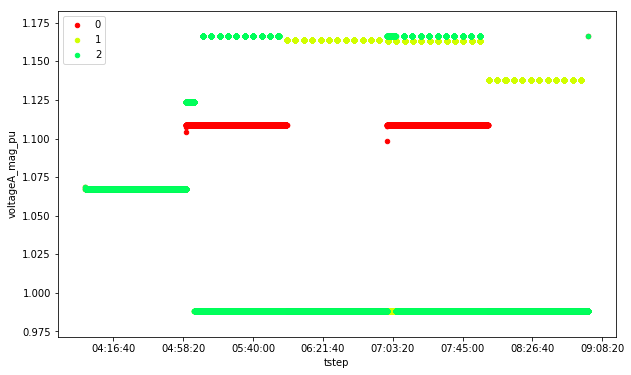

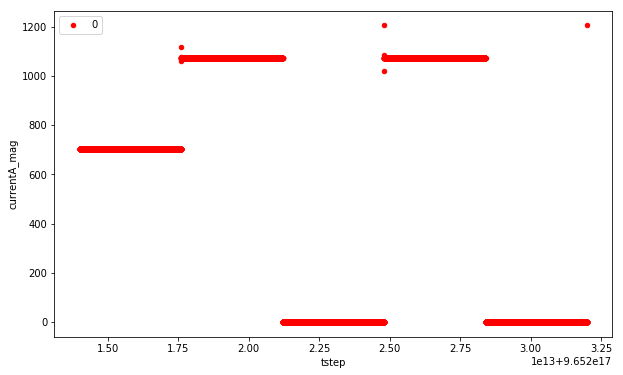

In [167]:
make_mini_plots('voltageA_mag_pu',df_list=[vdata_gen2, vdata_inv, vdata_inv2], time_start='2000-08-02 11:00:00', time_end='2000-08-02 16:00:00', fname='voltage_finer_day')

make_mini_plots('currentA_mag',   df_list=[cdata_gen2, cdata_inv, cdata_inv2], time_start='2000-08-02 11:00:00', time_end='2000-08-02 16:00:00', fname='voltage_finer_day')






In [70]:
"""
Import functions for TMY2 and TMY3 data files.
"""

import re
import datetime
import dateutil
import io
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen

import pandas as pd


def readtmy3(filename=None, coerce_year=None, recolumn=True):
    '''
    Read a TMY3 file in to a pandas dataframe.

    Note that values contained in the metadata dictionary are unchanged
    from the TMY3 file (i.e. units are retained). In the case of any
    discrepencies between this documentation and the TMY3 User's Manual
    [1], the TMY3 User's Manual takes precedence.

    The TMY3 files were updated in Jan. 2015. This function requires the
    use of the updated files.

    Parameters
    ----------
    filename : None or string, default None
        If None, attempts to use a Tkinter file browser. A string can be
        a relative file path, absolute file path, or url.

    coerce_year : None or int, default None
        If supplied, the year of the data will be set to this value.

    recolumn : bool, default True
        If True, apply standard names to TMY3 columns. Typically this
        results in stripping the units from the column name.

    Returns
    -------
    Tuple of the form (data, metadata).

    data : DataFrame
        A pandas dataframe with the columns described in the table
        below. For more detailed descriptions of each component, please
        consult the TMY3 User's Manual ([1]), especially tables 1-1
        through 1-6.

    metadata : dict
        The site metadata available in the file.

    Notes
    -----

    The returned structures have the following fields.

    ===============   ======  ===================
    key               format  description
    ===============   ======  ===================
    altitude          Float   site elevation
    latitude          Float   site latitudeitude
    longitude         Float   site longitudeitude
    Name              String  site name
    State             String  state
    TZ                Float   UTC offset
    USAF              Int     USAF identifier
    ===============   ======  ===================

    =============================       ======================================================================================================================================================
    TMYData field                       description
    =============================       ======================================================================================================================================================
    TMYData.Index                       A pandas datetime index. NOTE, the index is currently timezone unaware, and times are set to local standard time (daylight savings is not indcluded)
    TMYData.ETR                         Extraterrestrial horizontal radiation recv'd during 60 minutes prior to timestamp, Wh/m^2
    TMYData.ETRN                        Extraterrestrial normal radiation recv'd during 60 minutes prior to timestamp, Wh/m^2
    TMYData.GHI                         Direct and diffuse horizontal radiation recv'd during 60 minutes prior to timestamp, Wh/m^2
    TMYData.GHISource                   See [1], Table 1-4
    TMYData.GHIUncertainty              Uncertainty based on random and bias error estimates                        see [2]
    TMYData.DNI                         Amount of direct normal radiation (modeled) recv'd during 60 mintues prior to timestamp, Wh/m^2
    TMYData.DNISource                   See [1], Table 1-4
    TMYData.DNIUncertainty              Uncertainty based on random and bias error estimates                        see [2]
    TMYData.DHI                         Amount of diffuse horizontal radiation recv'd during 60 minutes prior to timestamp, Wh/m^2
    TMYData.DHISource                   See [1], Table 1-4
    TMYData.DHIUncertainty              Uncertainty based on random and bias error estimates                        see [2]
    TMYData.GHillum                     Avg. total horizontal illuminance recv'd during the 60 minutes prior to timestamp, lx
    TMYData.GHillumSource               See [1], Table 1-4
    TMYData.GHillumUncertainty          Uncertainty based on random and bias error estimates                        see [2]
    TMYData.DNillum                     Avg. direct normal illuminance recv'd during the 60 minutes prior to timestamp, lx
    TMYData.DNillumSource               See [1], Table 1-4
    TMYData.DNillumUncertainty          Uncertainty based on random and bias error estimates                        see [2]
    TMYData.DHillum                     Avg. horizontal diffuse illuminance recv'd during the 60 minutes prior to timestamp, lx
    TMYData.DHillumSource               See [1], Table 1-4
    TMYData.DHillumUncertainty          Uncertainty based on random and bias error estimates                        see [2]
    TMYData.Zenithlum                   Avg. luminance at the sky's zenith during the 60 minutes prior to timestamp, cd/m^2
    TMYData.ZenithlumSource             See [1], Table 1-4
    TMYData.ZenithlumUncertainty        Uncertainty based on random and bias error estimates                        see [1] section 2.10
    TMYData.TotCld                      Amount of sky dome covered by clouds or obscuring phenonema at time stamp, tenths of sky
    TMYData.TotCldSource                See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.TotCldUnertainty            See [1], Table 1-6
    TMYData.OpqCld                      Amount of sky dome covered by clouds or obscuring phenonema that prevent observing the sky at time stamp, tenths of sky
    TMYData.OpqCldSource                See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.OpqCldUncertainty           See [1], Table 1-6
    TMYData.DryBulb                     Dry bulb temperature at the time indicated, deg C
    TMYData.DryBulbSource               See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.DryBulbUncertainty          See [1], Table 1-6
    TMYData.DewPoint                    Dew-point temperature at the time indicated, deg C
    TMYData.DewPointSource              See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.DewPointUncertainty         See [1], Table 1-6
    TMYData.RHum                        Relatitudeive humidity at the time indicated, percent
    TMYData.RHumSource                  See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.RHumUncertainty             See [1], Table 1-6
    TMYData.Pressure                    Station pressure at the time indicated, 1 mbar
    TMYData.PressureSource              See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.PressureUncertainty         See [1], Table 1-6
    TMYData.Wdir                        Wind direction at time indicated, degrees from north (360 = north; 0 = undefined,calm)
    TMYData.WdirSource                  See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.WdirUncertainty             See [1], Table 1-6
    TMYData.Wspd                        Wind speed at the time indicated, meter/second
    TMYData.WspdSource                  See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.WspdUncertainty             See [1], Table 1-6
    TMYData.Hvis                        Distance to discernable remote objects at time indicated (7777=unlimited), meter
    TMYData.HvisSource                  See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.HvisUncertainty             See [1], Table 1-6
    TMYData.CeilHgt                     Height of cloud base above local terrain (7777=unlimited), meter
    TMYData.CeilHgtSource               See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.CeilHgtUncertainty          See [1], Table 1-6
    TMYData.Pwat                        Total precipitable water contained in a column of unit cross section from earth to top of atmosphere, cm
    TMYData.PwatSource                  See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.PwatUncertainty             See [1], Table 1-6
    TMYData.AOD                         The broadband aerosol optical depth per unit of air mass due to extinction by aerosol component of atmosphere, unitless
    TMYData.AODSource                   See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.AODUncertainty              See [1], Table 1-6
    TMYData.Alb                         The ratio of reflected solar irradiance to global horizontal irradiance, unitless
    TMYData.AlbSource                   See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.AlbUncertainty              See [1], Table 1-6
    TMYData.Lprecipdepth                The amount of liquid precipitation observed at indicated time for the period indicated in the liquid precipitation quantity field, millimeter
    TMYData.Lprecipquantity             The period of accumulatitudeion for the liquid precipitation depth field, hour
    TMYData.LprecipSource               See [1], Table 1-5, 8760x1 cell array of strings
    TMYData.LprecipUncertainty          See [1], Table 1-6
    TMYData.PresWth                     Present weather code, see [2].
    TMYData.PresWthSource               Present weather code source, see [2].
    TMYData.PresWthUncertainty          Present weather code uncertainty, see [2].
    =============================       ======================================================================================================================================================

    References
    ----------

    [1] Wilcox, S and Marion, W. "Users Manual for TMY3 Data Sets".
    NREL/TP-581-43156, Revised May 2008.

    [2] Wilcox, S. (2007). National Solar Radiation Database 1991 2005
    Update: Users Manual. 472 pp.; NREL Report No. TP-581-41364.
    '''

    if filename is None:
        try:
            filename = _interactive_load()
        except:
            raise Exception('Interactive load failed. Tkinter not supported '
                            'on this system. Try installing X-Quartz and '
                            'reloading')

    head = ['USAF', 'Name', 'State', 'TZ', 'latitude', 'longitude', 'altitude']

    try:
        csvdata = open(filename, 'r')
    except IOError:
        response = urlopen(filename)
        csvdata = io.StringIO(response.read().decode(errors='ignore'))

    # read in file metadata
    meta = dict(zip(head, csvdata.readline().rstrip('\n').split(",")))

    # convert metadata strings to numeric types
    meta['altitude'] = float(meta['altitude'])
    meta['latitude'] = float(meta['latitude'])
    meta['longitude'] = float(meta['longitude'])
    meta['TZ'] = float(meta['TZ'])
    meta['USAF'] = int(meta['USAF'])

    data = pd.read_csv(
        filename, header=1,
        parse_dates={'datetime': ['Date (MM/DD/YYYY)', 'Time (HH:MM)']},
        date_parser=lambda *x: _parsedate(*x, year=coerce_year),
        index_col='datetime')

    if recolumn:
        data = _recolumn(data)  # rename to standard column names

    data = data.tz_localize(int(meta['TZ']*3600))

    return data, meta



def _interactive_load():
    import Tkinter
    from tkFileDialog import askopenfilename
    Tkinter.Tk().withdraw()  # Start interactive file input
    return askopenfilename()


def _parsedate(ymd, hour, year=None):
    # stupidly complicated due to TMY3's usage of hour 24
    # and dateutil's inability to handle that.
    offset_hour = int(hour[:2]) - 1
    offset_datetime = '{} {}:00'.format(ymd, offset_hour)
    offset_date = dateutil.parser.parse(offset_datetime)
    true_date = offset_date + dateutil.relativedelta.relativedelta(hours=1)
    if year is not None:
        true_date = true_date.replace(year=year)
    return true_date


def _recolumn(tmy3_dataframe):
    """
    Rename the columns of the TMY3 DataFrame.

    Parameters
    ----------
    tmy3_dataframe : DataFrame
    inplace : bool
        passed to DataFrame.rename()

    Returns
    -------
    Recolumned DataFrame.
    """
    raw_columns = 'ETR (W/m^2),ETRN (W/m^2),GHI (W/m^2),GHI source,GHI uncert (%),DNI (W/m^2),DNI source,DNI uncert (%),DHI (W/m^2),DHI source,DHI uncert (%),GH illum (lx),GH illum source,Global illum uncert (%),DN illum (lx),DN illum source,DN illum uncert (%),DH illum (lx),DH illum source,DH illum uncert (%),Zenith lum (cd/m^2),Zenith lum source,Zenith lum uncert (%),TotCld (tenths),TotCld source,TotCld uncert (code),OpqCld (tenths),OpqCld source,OpqCld uncert (code),Dry-bulb (C),Dry-bulb source,Dry-bulb uncert (code),Dew-point (C),Dew-point source,Dew-point uncert (code),RHum (%),RHum source,RHum uncert (code),Pressure (mbar),Pressure source,Pressure uncert (code),Wdir (degrees),Wdir source,Wdir uncert (code),Wspd (m/s),Wspd source,Wspd uncert (code),Hvis (m),Hvis source,Hvis uncert (code),CeilHgt (m),CeilHgt source,CeilHgt uncert (code),Pwat (cm),Pwat source,Pwat uncert (code),AOD (unitless),AOD source,AOD uncert (code),Alb (unitless),Alb source,Alb uncert (code),Lprecip depth (mm),Lprecip quantity (hr),Lprecip source,Lprecip uncert (code),PresWth (METAR code),PresWth source,PresWth uncert (code)'

    new_columns = [
        'ETR', 'ETRN', 'GHI', 'GHISource', 'GHIUncertainty',
        'DNI', 'DNISource', 'DNIUncertainty', 'DHI', 'DHISource',
        'DHIUncertainty', 'GHillum', 'GHillumSource', 'GHillumUncertainty',
        'DNillum', 'DNillumSource', 'DNillumUncertainty', 'DHillum',
        'DHillumSource', 'DHillumUncertainty', 'Zenithlum',
        'ZenithlumSource', 'ZenithlumUncertainty', 'TotCld', 'TotCldSource',
        'TotCldUnertainty', 'OpqCld', 'OpqCldSource', 'OpqCldUncertainty',
        'DryBulb', 'DryBulbSource', 'DryBulbUncertainty', 'DewPoint',
        'DewPointSource', 'DewPointUncertainty', 'RHum', 'RHumSource',
        'RHumUncertainty', 'Pressure', 'PressureSource',
        'PressureUncertainty', 'Wdir', 'WdirSource', 'WdirUncertainty',
        'Wspd', 'WspdSource', 'WspdUncertainty', 'Hvis', 'HvisSource',
        'HvisUncertainty', 'CeilHgt', 'CeilHgtSource', 'CeilHgtUncertainty',
        'Pwat', 'PwatSource', 'PwatUncertainty', 'AOD', 'AODSource',
        'AODUncertainty', 'Alb', 'AlbSource', 'AlbUncertainty',
        'Lprecipdepth', 'Lprecipquantity', 'LprecipSource',
        'LprecipUncertainty', 'PresWth', 'PresWthSource',
        'PresWthUncertainty']

    mapping = dict(zip(raw_columns.split(','), new_columns))

    return tmy3_dataframe.rename(columns=mapping)


def readtmy2(filename):
    '''
    Read a TMY2 file in to a DataFrame.

    Note that values contained in the DataFrame are unchanged from the
    TMY2 file (i.e. units  are retained). Time/Date and location data
    imported from the TMY2 file have been modified to a "friendlier"
    form conforming to modern conventions (e.g. N latitude is postive, E
    longitude is positive, the "24th" hour of any day is technically the
    "0th" hour of the next day). In the case of any discrepencies
    between this documentation and the TMY2 User's Manual [1], the TMY2
    User's Manual takes precedence.

    Parameters
    ----------
    filename : None or string
        If None, attempts to use a Tkinter file browser. A string can be
        a relative file path, absolute file path, or url.

    Returns
    -------
    Tuple of the form (data, metadata).

    data : DataFrame
        A dataframe with the columns described in the table below. For a
        more detailed descriptions of each component, please consult the
        TMY2 User's Manual ([1]), especially tables 3-1 through 3-6, and
        Appendix B.

    metadata : dict
        The site metadata available in the file.

    Notes
    -----

    The returned structures have the following fields.

    =============    ==================================
    key              description
    =============    ==================================
    WBAN             Site identifier code (WBAN number)
    City             Station name
    State            Station state 2 letter designator
    TZ               Hours from Greenwich
    latitude         Latitude in decimal degrees
    longitude        Longitude in decimal degrees
    altitude         Site elevation in meters
    =============    ==================================

    ============================   ==========================================================================================================================================================================
    TMYData field                   description
    ============================   ==========================================================================================================================================================================
    index                           Pandas timeseries object containing timestamps
    year
    month
    day
    hour
    ETR                             Extraterrestrial horizontal radiation recv'd during 60 minutes prior to timestamp, Wh/m^2
    ETRN                            Extraterrestrial normal radiation recv'd during 60 minutes prior to timestamp, Wh/m^2
    GHI                             Direct and diffuse horizontal radiation recv'd during 60 minutes prior to timestamp, Wh/m^2
    GHISource                       See [1], Table 3-3
    GHIUncertainty                  See [1], Table 3-4
    DNI                             Amount of direct normal radiation (modeled) recv'd during 60 mintues prior to timestamp, Wh/m^2
    DNISource                       See [1], Table 3-3
    DNIUncertainty                  See [1], Table 3-4
    DHI                             Amount of diffuse horizontal radiation recv'd during 60 minutes prior to timestamp, Wh/m^2
    DHISource                       See [1], Table 3-3
    DHIUncertainty                  See [1], Table 3-4
    GHillum                         Avg. total horizontal illuminance recv'd during the 60 minutes prior to timestamp, units of 100 lux (e.g. value of 50 = 5000 lux)
    GHillumSource                   See [1], Table 3-3
    GHillumUncertainty              See [1], Table 3-4
    DNillum                         Avg. direct normal illuminance recv'd during the 60 minutes prior to timestamp, units of 100 lux
    DNillumSource                   See [1], Table 3-3
    DNillumUncertainty              See [1], Table 3-4
    DHillum                         Avg. horizontal diffuse illuminance recv'd during the 60 minutes prior to timestamp, units of 100 lux
    DHillumSource                   See [1], Table 3-3
    DHillumUncertainty              See [1], Table 3-4
    Zenithlum                       Avg. luminance at the sky's zenith during the 60 minutes prior to timestamp, units of 10 Cd/m^2 (e.g. value of 700 = 7,000 Cd/m^2)
    ZenithlumSource                 See [1], Table 3-3
    ZenithlumUncertainty            See [1], Table 3-4
    TotCld                          Amount of sky dome covered by clouds or obscuring phenonema at time stamp, tenths of sky
    TotCldSource                    See [1], Table 3-5, 8760x1 cell array of strings
    TotCldUnertainty                See [1], Table 3-6
    OpqCld                          Amount of sky dome covered by clouds or obscuring phenonema that prevent observing the sky at time stamp, tenths of sky
    OpqCldSource                    See [1], Table 3-5, 8760x1 cell array of strings
    OpqCldUncertainty               See [1], Table 3-6
    DryBulb                         Dry bulb temperature at the time indicated, in tenths of degree C (e.g. 352 = 35.2 C).
    DryBulbSource                   See [1], Table 3-5, 8760x1 cell array of strings
    DryBulbUncertainty              See [1], Table 3-6
    DewPoint                        Dew-point temperature at the time indicated, in tenths of degree C (e.g. 76 = 7.6 C).
    DewPointSource                  See [1], Table 3-5, 8760x1 cell array of strings
    DewPointUncertainty             See [1], Table 3-6
    RHum                            Relative humidity at the time indicated, percent
    RHumSource                      See [1], Table 3-5, 8760x1 cell array of strings
    RHumUncertainty                 See [1], Table 3-6
    Pressure                        Station pressure at the time indicated, 1 mbar
    PressureSource                  See [1], Table 3-5, 8760x1 cell array of strings
    PressureUncertainty             See [1], Table 3-6
    Wdir                            Wind direction at time indicated, degrees from east of north (360 = 0 = north; 90 = East; 0 = undefined,calm)
    WdirSource                      See [1], Table 3-5, 8760x1 cell array of strings
    WdirUncertainty                 See [1], Table 3-6
    Wspd                            Wind speed at the time indicated, in tenths of meters/second (e.g. 212 = 21.2 m/s)
    WspdSource                      See [1], Table 3-5, 8760x1 cell array of strings
    WspdUncertainty                 See [1], Table 3-6
    Hvis                            Distance to discernable remote objects at time indicated (7777=unlimited, 9999=missing data), in tenths of kilometers (e.g. 341 = 34.1 km).
    HvisSource                      See [1], Table 3-5, 8760x1 cell array of strings
    HvisUncertainty                 See [1], Table 3-6
    CeilHgt                         Height of cloud base above local terrain (7777=unlimited, 88888=cirroform, 99999=missing data), in meters
    CeilHgtSource                   See [1], Table 3-5, 8760x1 cell array of strings
    CeilHgtUncertainty              See [1], Table 3-6
    Pwat                            Total precipitable water contained in a column of unit cross section from Earth to top of atmosphere, in millimeters
    PwatSource                      See [1], Table 3-5, 8760x1 cell array of strings
    PwatUncertainty                 See [1], Table 3-6
    AOD                             The broadband aerosol optical depth (broadband turbidity) in thousandths on the day indicated (e.g. 114 = 0.114)
    AODSource                       See [1], Table 3-5, 8760x1 cell array of strings
    AODUncertainty                  See [1], Table 3-6
    SnowDepth                       Snow depth in centimeters on the day indicated, (999 = missing data).
    SnowDepthSource                 See [1], Table 3-5, 8760x1 cell array of strings
    SnowDepthUncertainty            See [1], Table 3-6
    LastSnowfall                    Number of days since last snowfall (maximum value of 88, where 88 = 88 or greater days; 99 = missing data)
    LastSnowfallSource              See [1], Table 3-5, 8760x1 cell array of strings
    LastSnowfallUncertainty         See [1], Table 3-6
    PresentWeather                  See [1], Appendix B, an 8760x1 cell array of strings. Each string contains 10 numeric values. The string can be parsed to determine each of 10 observed weather metrics.
    ============================   ==========================================================================================================================================================================

    References
    ----------

    [1] Marion, W and Urban, K. "Wilcox, S and Marion, W. "User's Manual
    for TMY2s". NREL 1995.
    '''

    if filename is None:
        try:
            filename = _interactive_load()
        except:
            raise Exception('Interactive load failed. Tkinter not supported on this system. Try installing X-Quartz and reloading')

    string = '%2d%2d%2d%2d%4d%4d%4d%1s%1d%4d%1s%1d%4d%1s%1d%4d%1s%1d%4d%1s%1d%4d%1s%1d%4d%1s%1d%2d%1s%1d%2d%1s%1d%4d%1s%1d%4d%1s%1d%3d%1s%1d%4d%1s%1d%3d%1s%1d%3d%1s%1d%4d%1s%1d%5d%1s%1d%10d%3d%1s%1d%3d%1s%1d%3d%1s%1d%2d%1s%1d'
    columns = 'year,month,day,hour,ETR,ETRN,GHI,GHISource,GHIUncertainty,DNI,DNISource,DNIUncertainty,DHI,DHISource,DHIUncertainty,GHillum,GHillumSource,GHillumUncertainty,DNillum,DNillumSource,DNillumUncertainty,DHillum,DHillumSource,DHillumUncertainty,Zenithlum,ZenithlumSource,ZenithlumUncertainty,TotCld,TotCldSource,TotCldUnertainty,OpqCld,OpqCldSource,OpqCldUncertainty,DryBulb,DryBulbSource,DryBulbUncertainty,DewPoint,DewPointSource,DewPointUncertainty,RHum,RHumSource,RHumUncertainty,Pressure,PressureSource,PressureUncertainty,Wdir,WdirSource,WdirUncertainty,Wspd,WspdSource,WspdUncertainty,Hvis,HvisSource,HvisUncertainty,CeilHgt,CeilHgtSource,CeilHgtUncertainty,PresentWeather,Pwat,PwatSource,PwatUncertainty,AOD,AODSource,AODUncertainty,SnowDepth,SnowDepthSource,SnowDepthUncertainty,LastSnowfall,LastSnowfallSource,LastSnowfallUncertaint'
    hdr_columns = 'WBAN,City,State,TZ,latitude,longitude,altitude'

    TMY2, TMY2_meta = _read_tmy2(string, columns, hdr_columns, filename)

    return TMY2, TMY2_meta



def _parsemeta_tmy2(columns, line):
    """Retrieves metadata from the top line of the tmy2 file.

    Parameters
    ----------
    columns : string
        String of column headings in the header

    line : string
        Header string containing DataFrame

    Returns
    -------
    meta : Dict of metadata contained in the header string
    """
    # Remove duplicated spaces, and read in each element
    rawmeta = " ".join(line.split()).split(" ")
    meta = rawmeta[:3]  # take the first string entries
    meta.append(int(rawmeta[3]))
    # Convert to decimal notation with S negative
    longitude = (
        float(rawmeta[5]) + float(rawmeta[6])/60) * (2*(rawmeta[4] == 'N') - 1)
    # Convert to decimal notation with W negative
    latitude = (
        float(rawmeta[8]) + float(rawmeta[9])/60) * (2*(rawmeta[7] == 'E') - 1)
    meta.append(longitude)
    meta.append(latitude)
    meta.append(float(rawmeta[10]))

    # Creates a dictionary of metadata
    meta_dict = dict(zip(columns.split(','), meta))
    return meta_dict


def _read_tmy2(string, columns, hdr_columns, fname):
    head = 1
    date = []
    with open(fname) as infile:
        fline = 0
        for line in infile:
            # Skip the header
            if head != 0:
                meta = _parsemeta_tmy2(hdr_columns, line)
                head -= 1
                continue
            # Reset the cursor and array for each line
            cursor = 1
            part = []
            for marker in string.split('%'):
                # Skip the first line of markers
                if marker == '':
                    continue

                # Read the next increment from the marker list
                increment = int(re.findall('\d+', marker)[0])

                # Extract the value from the line in the file
                val = (line[cursor:cursor+increment])
                # increment the cursor by the length of the read value
                cursor = cursor+increment

                # Determine the datatype from the marker string
                if marker[-1] == 'd':
                    try:
                        val = float(val)
                    except:
                        raise Exception('WARNING: In {} Read value is not an '
                                        'integer " {} " '.format(fname, val))
                elif marker[-1] == 's':
                    try:
                        val = str(val)
                    except:
                        raise Exception('WARNING: In {} Read value is not a '
                                        'string " {} " '.format(fname, val))
                else:
                    raise Exception('WARNING: In {} Improper column DataFrame '
                                    '" %{} " '.format(__name__, marker))

                part.append(val)

            if fline == 0:
                axes = [part]
                year = part[0]+1900
                fline = 1
            else:
                axes.append(part)

            # Create datetime objects from read data
            date.append(datetime.datetime(year=int(year),
                                          month=int(part[1]),
                                          day=int(part[2]),
                                          hour=int(part[3])-1))

    data = pd.DataFrame(
        axes, index=date,
        columns=columns.split(',')).tz_localize(int(meta['TZ']*3600))

    return data, meta


In [82]:
hilo_tmy, hilo_tmy_meta = readtmy2('hilo.tmy2')

In [116]:
hilo_tmy[5112:]


,year,month,day,hour,ETR,ETRN,GHI,GHISource,GHIUncertainty,DNI,...,PwatUncertainty,AOD,AODSource,AODUncertainty,SnowDepth,SnowDepthSource,SnowDepthUncertainty,LastSnowfall,LastSnowfallSource,LastSnowfallUncertaint
1969-08-02 00:00:00-10:00,76.0,8.0,2.0,1.0,0.0,0.0,0.0,?,0.0,0.0,...,7.0,40.0,F,8.0,0.0,A,7.0,88.0,E,7.0
1969-08-02 01:00:00-10:00,76.0,8.0,2.0,2.0,0.0,0.0,0.0,?,0.0,0.0,...,7.0,40.0,F,8.0,0.0,A,7.0,88.0,E,7.0
1969-08-02 02:00:00-10:00,76.0,8.0,2.0,3.0,0.0,0.0,0.0,?,0.0,0.0,...,7.0,40.0,F,8.0,0.0,A,7.0,88.0,E,7.0
1969-08-02 03:00:00-10:00,76.0,8.0,2.0,4.0,0.0,0.0,0.0,?,0.0,0.0,...,7.0,40.0,F,8.0,0.0,A,7.0,88.0,E,7.0
1969-08-02 04:00:00-10:00,76.0,8.0,2.0,5.0,0.0,0.0,0.0,?,0.0,0.0,...,7.0,40.0,F,8.0,0.0,A,7.0,88.0,E,7.0
1969-08-02 05:00:00-10:00,76.0,8.0,2.0,6.0,0.0,0.0,0.0,?,0.0,0.0,...,7.0,40.0,F,8.0,0.0,A,7.0,88.0,E,7.0
1969-08-02 06:00:00-10:00,76.0,8.0,2.0,7.0,156.0,1327.0,34.0,H,5.0,5.0,...,7.0,40.0,F,8.0,0.0,A,7.0,88.0,E,7.0
1969-08-02 07:00:00-10:00,76.0,8.0,2.0,8.0,462.0,1327.0,138.0,G,4.0,28.0,...,7.0,40.0,F,8.0,0.0,A,7.0,88.0,E,7.0
1969-08-02 08:00:00-10:00,76.0,8.0,2.0,9.0,746.0,1327.0,216.0,H,4.0,3.0,...,7.0,40.0,F,8.0,0.0,A,7.0,88.0,E,7.0
1969-08-02 09:00:00-10:00,76.0,8.0,2.0,10.0,990.0,1327.0,350.0,H,4.0,96.0,...,7.0,40.0,F,8.0,0.0,A,7.0,88.0,E,7.0


In [ ]:
make_mini_plots('voltageA_mag_pu',df=vdata_ctrl,time_start='2000-08-02 00:00:00', time_end='2000-08-03 00:00:00', fname='voltage_control_day')
make_mini_plots('voltageA_mag_pu',df=vdata_new,time_start='2000-08-02 00:00:00', time_end='2000-08-03 00:00:00', fname='voltage_IEEE_check_day')
make_mini_plots('voltageA_mag_pu',df=vdata_nodelta,time_start='2000-08-02 00:00:00', time_end='2000-08-03 00:00:00', fname='voltage_nodelta_day')

In [ ]:
make_mini_plots('currentA_mag',df=cdata_ctrl,time_start='2000-08-02 00:00:00', time_end='2000-08-03 00:00:00', fname='current_control_day')
make_mini_plots('currentA_mag',df=cdata_new,time_start='2000-08-02 00:00:00', time_end='2000-08-03 00:00:00', fname='current_IEEE_check_day')
make_mini_plots('currentA_mag',df=cdata_nodelta,time_start='2000-08-02 00:00:00', time_end='2000-08-03 00:00:00', fname='current_nodelta_day')

(1.0, 0.0, 0.0, 1.0)
(1.0, 0.84375084375084364, 0.0, 1.0)
(0.31249831249831239, 1.0, 0.0, 1.0)
(0.0, 1.0, 0.53124957812723606, 1.0)


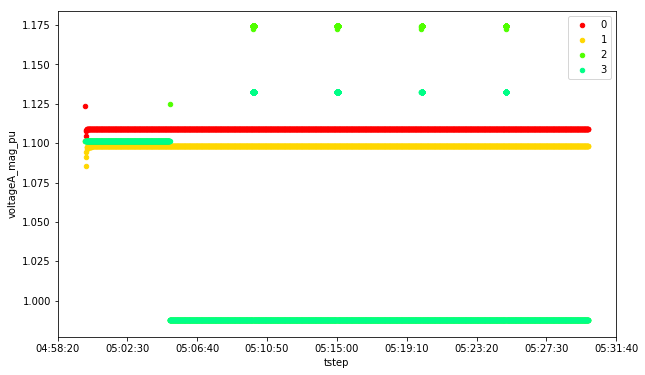

In [13]:
make_mini_plots('voltageA_mag_pu',df_list=[vdata_nodelta, vdata_ctrl, vdata_new, vdata_gen], time_start='2000-08-02 12:00:00', time_end='2000-08-02 12:30:00', fname='voltage_finer_day')

In [ ]:
make_mini_plots('currentA_mag',df_list=[cdata_nodelta, cdata_ctrl, cdata_new], time_start='2000-08-02 12:00:00', time_end='2000-08-02 12:30:00', fname='current_finer_day')

In [ ]:
make_mini_plots('currentA_mag',df_list=[cdata_nodelta, cdata_ctrl, cdata_new], time_start='2000-08-02 12:00:00', time_end='2000-08-02 12:30:00', fname='current_finer_day')

In [ ]:
vdata_nodelta.name = 'hello'

In [ ]:
data = pd.read_csv('generators/autotest/test_deltamode_diesel_dg_pctests/bus_1_output_recorder_with_delta.csv',skiprows=8)

data[['voltage_A.real']].plot()

In [ ]:
data = pd.read_csv('generators/autotest/test_deltamode_diesel_dg_pctest_break/bus_1_output_recorder_without_deltamode.csv',skiprows=8)
data[['voltage_A.real']].plot()

In [ ]:
data['2000-08-02 12:05:00.000':'2000-08-02 12:05:04.000'][['voltageA_mag','voltageB_mag','voltageC_mag']]

In [ ]:
data['2000-08-02 12:00:00':'2000-08-02 12:01:00'][['voltageB_mag']].plot()

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
data[['voltageA_mag']].plot(ax=ax)
#set ticks every week
ax.xaxis.set_major_locator(mdates.HourLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))


In [ ]:
Location = r'time_results/meter_data/voltage/m680.csv'
df = pd.read_csv(Location, skiprows=8)

In [ ]:
type(df.loc[:, ['# timestamp', 'voltage_A.real']])

In [ ]:
type(df[['# timestamp', 'voltage_A.real']].plot())

In [ ]:
new_df = df.set_index(df['# timestamp'])

In [ ]:
new_df.plot(figsize=(15,15))

In [ ]:
new_df.columns

In [ ]:
data

In [ ]:
data['voltageA'] = data.apply(lambda x: complex(x[1],x[2]), axis=1)

In [ ]:
data['voltageA_mag'] = data.apply(lambda x: abs(complex(x[1],x[2])), axis=1)

In [ ]:
import math
import cmath
data['voltageA_deg'] = data.apply(lambda x: cmath.phase(complex(x[1],x[2])) * 180 / (2 * math.pi), axis=1)

In [ ]:
df.set_index('# timestamp',inplace=True)

#plot data
fig, ax = plt.subplots(figsize=(15,7))
df[['voltageA_mag']].plot(ax=ax)

#set ticks every week
ax.xaxis.set_major_locator(mdates.HourLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))